<a href="https://colab.research.google.com/github/anuragdhirubhai/speech_classification_prjct/blob/master/Speech_recognition_catDog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# New Section

In [ ]:
!pip install tensorflow

In [4]:
pip install tensorflow-io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio

Building a Data Loading Function

In [6]:
cat_file = os.path.join('gdrive', 'MyDrive', 'speech_project', 'cats','cat_3.wav')
dog_file = os.path.join('gdrive', 'MyDrive', 'speech_project', 'dogs', 'dog_barking_0.wav')

In [7]:
print(cat_file)
print(dog_file)

gdrive/MyDrive/speech_project/cats/cat_3.wav
gdrive/MyDrive/speech_project/dogs/dog_barking_0.wav


Building a function to load data from tensorflow documentation: and check each step of the function


In [8]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=44100, rate_out=16000)
    return wav

In [9]:
wave_cat = load_wav_16k_mono(cat_file)
wave_dog = load_wav_16k_mono(dog_file)

In [ ]:
file_contents = tf.io.read_file(cat_file)
#this will give us the string of the cat_file.
file_contents

In [11]:
 wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
 wav

<tf.Tensor: shape=(187200, 1), dtype=float32, numpy=
array([[2.3864746e-02],
       [2.4108887e-02],
       [2.2766113e-02],
       ...,
       [3.6926270e-03],
       [2.2277832e-03],
       [3.0517578e-05]], dtype=float32)>

In [12]:
sample_rate

<tf.Tensor: shape=(), dtype=int32, numpy=16000>

In [13]:
len(wav)

187200

In [14]:
wav = tfio.audio.resample(wav, rate_in=44100, rate_out=16000)
len(wav)

67918

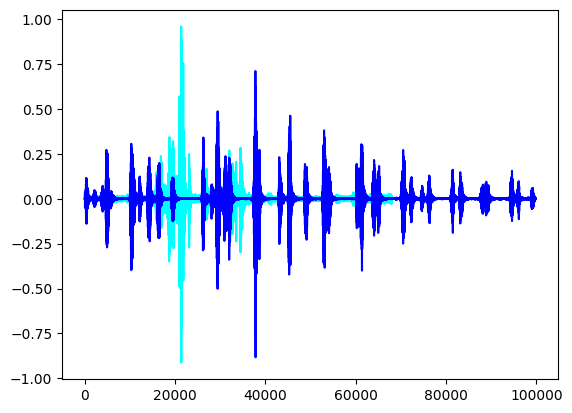

In [15]:
plt.plot(wave_cat,color='cyan')
plt.plot(wave_dog, color='blue')
plt.show()

Definning path for dogs and cats file
to create a tensorflow dataset

In [16]:
cat_path = os.path.join('gdrive', 'MyDrive', 'speech_project', 'cats')
dog_path = os.path.join('gdrive', 'MyDrive', 'speech_project', 'dogs')

In [17]:
import os
cat_path = '/content/gdrive/MyDrive/speech_project/cats'
print(os.listdir(cat_path))

['cat_10.wav', 'cat_101.wav', 'cat_103.wav', 'cat_105.wav', 'cat_102.wav', 'cat_100.wav', 'cat_1.wav', 'cat_120.wav', 'cat_11.wav', 'cat_113.wav', 'cat_106.wav', 'cat_112.wav', 'cat_124.wav', 'cat_114.wav', 'cat_121.wav', 'cat_109.wav', 'cat_122.wav', 'cat_116.wav', 'cat_110.wav', 'cat_107.wav', 'cat_108.wav', 'cat_115.wav', 'cat_117.wav', 'cat_118.wav', 'cat_123.wav', 'cat_119.wav', 'cat_12.wav', 'cat_133.wav', 'cat_126.wav', 'cat_129.wav', 'cat_142.wav', 'cat_135.wav', 'cat_139.wav', 'cat_127.wav', 'cat_131.wav', 'cat_134.wav', 'cat_132.wav', 'cat_141.wav', 'cat_138.wav', 'cat_14.wav', 'cat_125.wav', 'cat_137.wav', 'cat_136.wav', 'cat_140.wav', 'cat_130.wav', 'cat_13.wav', 'cat_128.wav', 'cat_159.wav', 'cat_16.wav', 'cat_156.wav', 'cat_154.wav', 'cat_147.wav', 'cat_155.wav', 'cat_158.wav', 'cat_146.wav', 'cat_161.wav', 'cat_149.wav', 'cat_153.wav', 'cat_160.wav', 'cat_144.wav', 'cat_151.wav', 'cat_15.wav', 'cat_152.wav', 'cat_143.wav', 'cat_150.wav', 'cat_148.wav', 'cat_157.wav', 'ca

Creating a tensorflow dataset


In [18]:
cat_pos = tf.data.Dataset.list_files(cat_path+'/*.wav')
dog_neg = tf.data.Dataset.list_files(dog_path+'/*.wav')

In [19]:
positives_for_cats = tf.data.Dataset.zip((cat_pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(cat_pos)))))
negatives_for_dogs = tf.data.Dataset.zip((dog_neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(dog_neg)))))
data = positives_for_cats.concatenate(negatives_for_dogs)

In [20]:
#wave length

In [21]:
lengths = []
for file in os.listdir(os.path.join('gdrive', 'MyDrive', 'speech_project', 'cats')):
    tensor_wave = load_wav_16k_mono(os.path.join('gdrive', 'MyDrive', 'speech_project', 'cats', file))
    lengths.append(len(tensor_wave))

Calculate Mean, Min and Max

In [22]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=48894>

In [23]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=5359>

In [24]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=381178>

Build Preprocessing Function to Convert to Spectrogram

In [25]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

Test Out the Function and Viz the Spectrogram

In [26]:
filepath, label = positives_for_cats.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [27]:
spectrogram, label = preprocess(filepath, label)

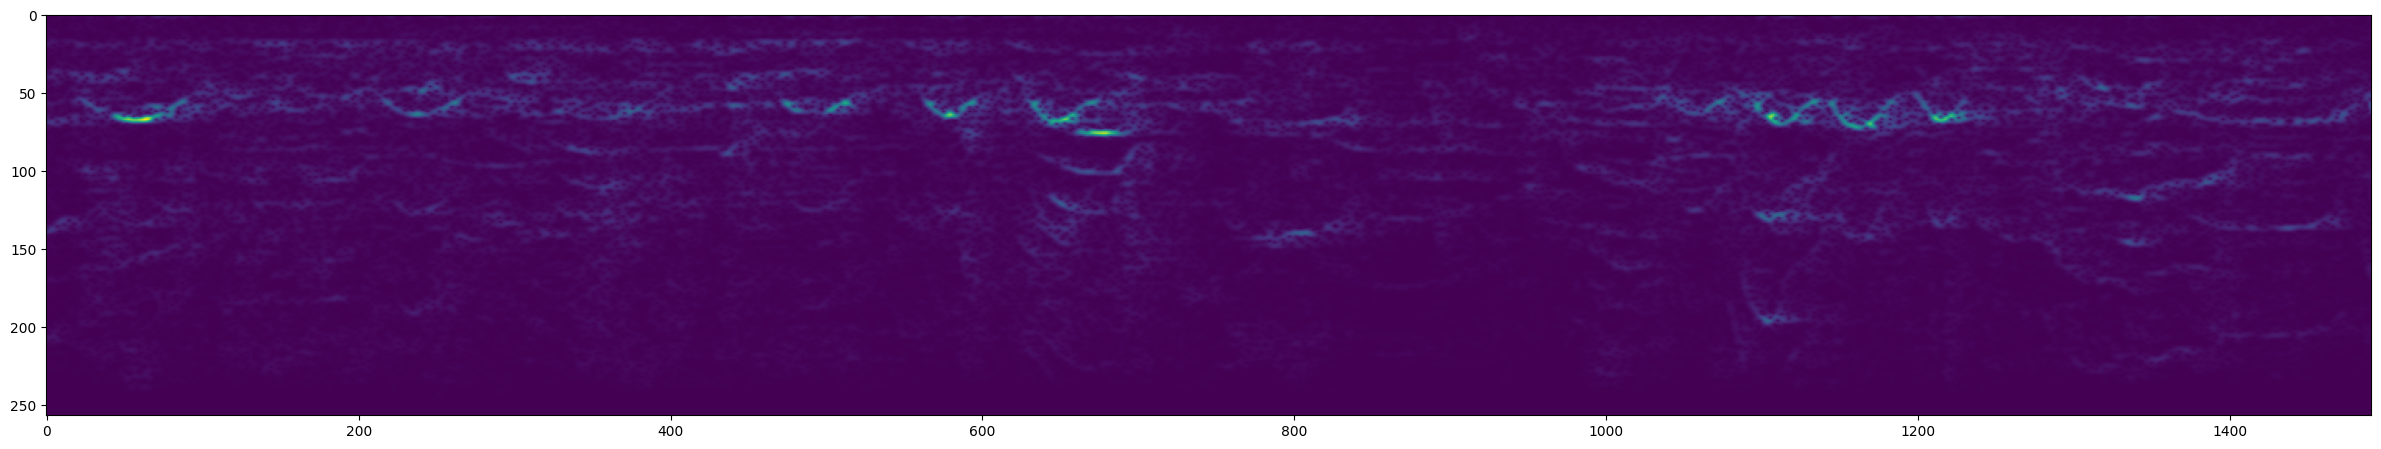

In [28]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

Create Training and Testing Partitions

Create a Tensorflow Data Pipeline

In [29]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)



Split into Training and Testing Partitions

In [30]:
from sklearn.model_selection import train_test_split


In [31]:
train = data.take(100)
test = data.skip(10).take(20)

Test One Batch

In [33]:
samples, labels = next(iter(train))

In [34]:
samples.shape

TensorShape([16, 1491, 257, 1])

In [35]:
print (len(samples))

16


Build Deep Learning Model

Load Tensorflow Dependencies

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [37]:
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout

Build Sequential Model, Compile and View Summary

In [38]:
# model = Sequential()
# model.add(Conv2D(32, (1,1), activation='relu', input_shape=(1491, 257,1)))
# model.add(Conv2D(32, (1,1), activation='relu'))
# model.add(Flatten())
# model.add(Dense(100, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
# # model = Sequential([
# #     Conv2D(32, (3,3), activation='relu', input_shape=(1491,257,1)),
# #     MaxPooling2D((2,2)),
# #     Flatten(),
# #     Dense(128, activation='relu'),
# #     Dense(1, activation='sigmoid')

model = Sequential()
model.add(Conv2D(16, (1,1), activation='relu', input_shape=(1491, 257,1)))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [39]:
model.compile(optimizer='adamax',
              metrics=['accuracy'],
              loss='binary_crossentropy')

In [40]:
class Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') >= 0.9:
            self.model.stop_training = True

Fit Model, View Loss and KPI Plots

In [41]:
history = model.fit(train,
                    epochs=3,
                    validation_data=test,
                    batch_size=64,  # increased batch size
                    steps_per_epoch=210//128, 
                    validation_steps=63//128, 
                    callbacks=[Callback()])

Epoch 1/3
1/1 [==============================] - 11s 11s/step - loss: 0.6905 - accuracy: 0.5625
Epoch 2/3
1/1 [==============================] - 10s 10s/step - loss: 2.7878 - accuracy: 0.8125
Epoch 3/3
1/1 [==============================] - 6s 6s/step - loss: 11.9847 - accuracy: 0.7500


In [42]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
18/18 [==============================] - 139s 8s/step - loss: 14.0789 - accuracy: 0.8587 - val_loss: 9.1762 - val_accuracy: 0.8537
Epoch 2/4
18/18 [==============================] - 121s 7s/step - loss: 4.6618 - accuracy: 0.8834 - val_loss: 1.2534 - val_accuracy: 0.8780
Epoch 3/4
18/18 [==============================] - 122s 7s/step - loss: 1.1338 - accuracy: 0.9364 - val_loss: 0.0288 - val_accuracy: 0.9919
Epoch 4/4
18/18 [==============================] - 123s 7s/step - loss: 0.0365 - accuracy: 0.9929 - val_loss: 8.2576e-04 - val_accuracy: 1.0000


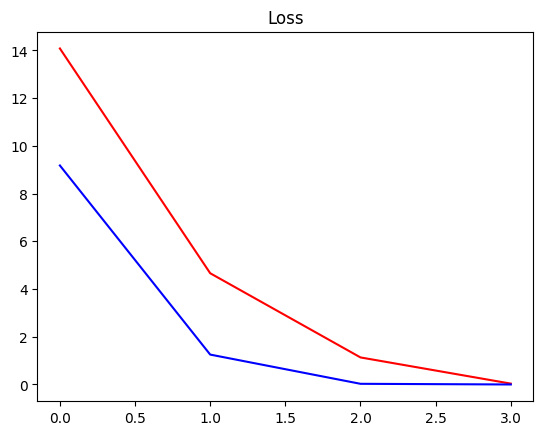

In [43]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

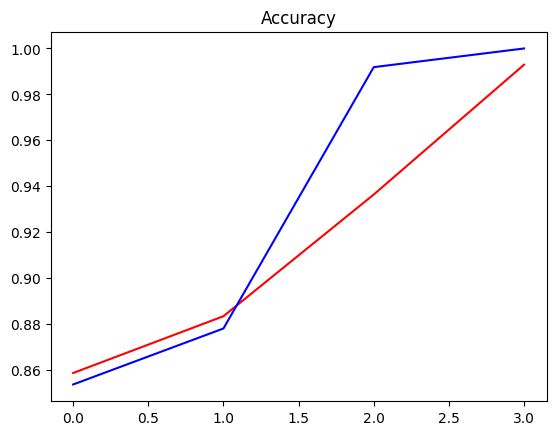

In [47]:
# plt.title('Precision')
# plt.plot(hist.history['precision'], 'r')
# plt.plot(hist.history['val_precision'], 'b')
# plt.show()
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], 'r')
plt.plot(hist.history['val_accuracy'], 'b')
plt.show()



In [48]:
print(hist.history.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


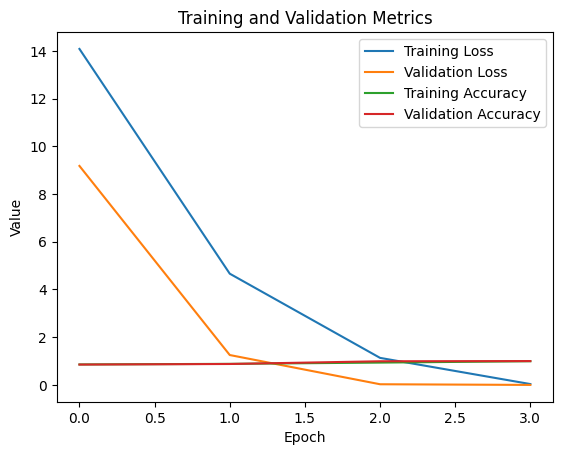

In [51]:
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()


Making prediction on single clip


In [52]:
X_test, y_test = test.as_numpy_iterator().next()

In [53]:
yhat = model.predict(X_test)

1/1 [==============================] - 1s 867ms/step
